In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [60]:
import torch
import torch.nn as nn
from neuralop.models import FNO2d
from neuralop.data.datasets import DarcyDataset, NavierStokesDataset
from torch.utils.data import DataLoader
import numpy as np
import copy
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import os

class CustomNavierStokesDataset(Dataset):
    def __init__(self, root_dir, n_train=1000, n_tests=[100], train_resolution=128, test_resolutions=[128],
                 batch_size=16, test_batch_sizes=[16], download=True):
        self.original_dataset = NavierStokesDataset(
            root_dir=root_dir,
            n_train=n_train,
            n_tests=n_tests,
            train_resolution=train_resolution,
            test_resolutions=test_resolutions,
            batch_size=batch_size,
            test_batch_sizes=test_batch_sizes,
            download=download
        )
        
        self.train_db = self.original_dataset.train_db
        self.test_dbs = self.original_dataset.test_dbs
        self.resolution = train_resolution
        
        # Get channel and shape information from a sample
        sample = self.train_db[0]
        raw_x, raw_y = sample['x'], sample['y']
        print(f"Raw x shape: {raw_x.shape}, Raw y shape: {raw_y.shape}")  # Debug raw shapes
        
        self.in_channels = raw_x.shape[0]  # (channels, height, width)
        self.out_channels = raw_y.shape[0]
        self.spatial_dims = raw_x.shape[1:]  # (height, width)
        print(f"Processed input shape: {raw_x.shape}, target shape: {raw_y.shape}")
        
        # Ensure train_db has even number of samples for pairing
        self.num_pairs = len(self.train_db) // 2
        if len(self.train_db) % 2 != 0:
            print(f"Warning: train_db has {len(self.train_db)} samples, truncating to {self.num_pairs * 2} for pairing")
        
    def __len__(self):
        return self.num_pairs  # Number of pairs (t=0, t=10)

    def __getitem__(self, idx):
        input_sample = self.train_db[idx * 2]  # t=0
        target_sample = self.train_db[idx * 2 + 1]  # t=10
        input_data = input_sample['x']  # Shape: (channels, height, width)
        target_data = target_sample['y']  # Shape: (channels, height, width)
        return {'x': input_data, 'y': target_data}

    def get_test_data(self, resolution):
        test_data = []
        num_test_pairs = len(self.test_dbs[resolution]) // 2
        for idx in range(num_test_pairs):
            input_sample = self.test_dbs[resolution][idx * 2]
            target_sample = self.test_dbs[resolution][idx * 2 + 1]
            input_data = input_sample['x']
            target_data = target_sample['y']
            test_data.append({'x': input_data, 'y': target_data})
        return test_data

def get_dataset_loader(dataset_name, batch_size):
    if dataset_name == "NavierStokes":
        dataset = CustomNavierStokesDataset(
            root_dir='./data/navier_stokes',
            n_train=1000,
            n_tests=[100],
            train_resolution=128,
            test_resolutions=[128],
            batch_size=batch_size,
            test_batch_sizes=[batch_size],
            download=True
        )
        
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(dataset.get_test_data(128), batch_size=batch_size, shuffle=False, num_workers=4)
        
        in_channels = dataset.in_channels
        out_channels = dataset.out_channels
        spatial_dims = dataset.spatial_dims
        
        return train_loader, test_loader, in_channels, out_channels, spatial_dims
    
    else:
        raise ValueError(f"Dataset {dataset_name} not supported in this custom loader.")
    
# 1. 모델 정의
#####################
# Model definitions
#####################

# FNO
class FNO(nn.Module):
    def __init__(self, n_modes_height=16, n_modes_width=16, hidden_channels=128, in_channels=1, out_channels=1, device="cuda"):
        super().__init__()
        self.fno = FNO2d(n_modes_height=n_modes_height,
        n_modes_width=n_modes_width,
        hidden_channels=hidden_channels,
        in_channels=in_channels,
        out_channels=out_channels,
        lifting_channels=hidden_channels).to(device)

    def forward(self, x):
        return self.fno(x)

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_channels=64, device="cuda"):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),  # 배치 정규화 추가
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, hidden_channels)
        self.enc2 = conv_block(hidden_channels, hidden_channels*2)
        self.enc3 = conv_block(hidden_channels*2, hidden_channels*4)
        self.middle = conv_block(hidden_channels*4, hidden_channels*8)
        self.upconv3 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, 2, stride=2)
        self.dec3 = conv_block(hidden_channels*8, hidden_channels*4)
        self.upconv2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, 2, stride=2)
        self.dec2 = conv_block(hidden_channels*4, hidden_channels*2)
        self.upconv1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, 2, stride=2)
        self.dec1 = conv_block(hidden_channels*2, hidden_channels)
        self.final = nn.Conv2d(hidden_channels, out_channels, 1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)  # 드롭아웃 추가
        self.to(device)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        m = self.middle(self.pool(e3))
        m = self.dropout(m)
        d3 = self.upconv3(m)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.final(d1)

# DeepONet
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        if len(layers) < 2:
            raise ValueError("At least two layers required.")
        self.model = nn.Sequential()
        for i in range(len(layers) - 2):
            self.model.add_module(f'fc{i}', nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f'act{i}', activation())
            self.model.add_module(f'drop{i}', nn.Dropout(0.3))  # 드롭아웃 추가
        self.model.add_module('fc_out', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.model(x)

class DeepONet(nn.Module):
    def __init__(self, input_dim=128*128, trunk_dim=2, latent_dim=200, H=128, W=128):
        super().__init__()
        self.H, self.W = H, W
        if input_dim != H * W:
            raise ValueError(f"input_dim ({input_dim}) must equal H*W ({H*W})")
        self.branch_net = MLP([input_dim, 400, 400, latent_dim])
        self.trunk_net = MLP([trunk_dim, 400, 400, latent_dim])
        grid_x = torch.linspace(-1, 1, H)
        grid_y = torch.linspace(-1, 1, W)
        X, Y = torch.meshgrid(grid_x, grid_y, indexing='ij')
        coords = torch.stack([X, Y], dim=-1).view(-1, 2)
        self.register_buffer("coords", coords)

    def forward(self, a_field):
        B, C, H, W = a_field.shape
        if C != 1:
            raise ValueError(f"Expected channel dimension to be 1, got {C}")
        if H != self.H or W != self.W:
            raise ValueError(f"Expected spatial dimensions ({self.H}, {self.W}), got ({H}, {W})")
        a_flat = a_field.view(B, -1)
        branch_out = self.branch_net(a_flat)
        coords = self.coords
        trunk_out = self.trunk_net(coords)
        trunk_out = trunk_out.expand(B, -1, -1)
        branch_out = branch_out.unsqueeze(1)
        out = torch.einsum('bmd,bnd->bn', branch_out, trunk_out)
        return out.view(B, 1, H, W)
        
# 2. Fine-tuning 함수
def fine_tune(model, optimizer, criterion, train_loader, lr, device):
    model.train()
    # all_outputs = []
    # all_targets = []
    train_loss = 0.0
    
    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # all_outputs.append(outputs.detach().cpu())
        # all_targets.append(targets.detach().cpu())
        train_loss += loss.item()

    # 전체 상대오차 계산
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)

    return model, copy.deepcopy(model.state_dict()), train_loss / len(train_loader)

def studygroup(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr, device):
    model1.train()
    # all_outputs1 = []
    # all_targets1 = []
    train_loss1 = 0.0
    model2.train()
    # all_outputs2 = []
    # all_targets2 = []
    train_loss2 = 0.0
    
    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        loss1 = criterion(outputs1, targets)
        loss2 = criterion(outputs2, targets)
        # total_loss1 += loss1.item()
        # total_loss2 += loss2.item()
        
        gap = torch.abs(outputs1 - targets) > torch.abs(outputs2 - targets)
        sign = torch.sign(outputs1 - targets) != torch.sign(outputs2 - targets)
        index1 = torch.where(torch.logical_and(gap, sign))
        index2 = torch.where(torch.logical_and(~gap, sign))
        index3 = torch.where(~sign)
        
        if index1[0].numel() > 0:
            loss1 = criterion(outputs1[index1[0], index1[1], index1[2], index1[3]], outputs2[index1[0], index1[1], index1[2], index1[3]].detach())
        if index3[0].numel() > 0:
            loss1 += criterion(outputs1[index3[0], index3[1], index3[2], index3[3]], targets[index3[0], index3[1], index3[2], index3[3]])
        loss1.backward()
        optimizer1.step()
        
        if index2[0].numel() > 0:
            loss2 = criterion(outputs2[index2[0], index2[1], index2[2], index2[3]], outputs1[index2[0], index2[1], index2[2], index2[3]].detach())
        if index3[0].numel() > 0:
            loss2 += criterion(outputs2[index3[0], index3[1], index3[2], index3[3]], targets[index3[0], index3[1], index3[2], index3[3]])        
        loss2.backward()
        optimizer2.step()
        
        # all_outputs1.append(outputs1.detach().cpu())
        # all_targets1.append(targets.detach().cpu())
        # all_outputs2.append(outputs2.detach().cpu())
        # all_targets2.append(targets.detach().cpu())
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        
    # outputs_all1 = torch.cat(all_outputs1, dim=0)
    # targets_all1 = torch.cat(all_targets1, dim=0)
    # rel_error1 = torch.norm(outputs_all1 - targets_all1) / torch.norm(targets_all1)
    # outputs_all2 = torch.cat(all_outputs2, dim=0)
    # targets_all2 = torch.cat(all_targets2, dim=0)
    # rel_error2 = torch.norm(outputs_all2 - targets_all2) / torch.norm(targets_all2)
    return model1, model2, copy.deepcopy(model1.state_dict()), copy.deepcopy(model2.state_dict()), train_loss1 / len(train_loader), train_loss2 / len(train_loader)

# 7. 평가 함수
def evaluate(model, test_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    # all_outputs = []
    # all_targets = []
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch["x"].to(device), batch["y"].to(device)
            outputs = model(inputs)
            # all_outputs.append(outputs.cpu())
            # all_targets.append(targets.cpu())
            test_loss += criterion(outputs, targets).item()
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)
    return test_loss / len(test_loader)

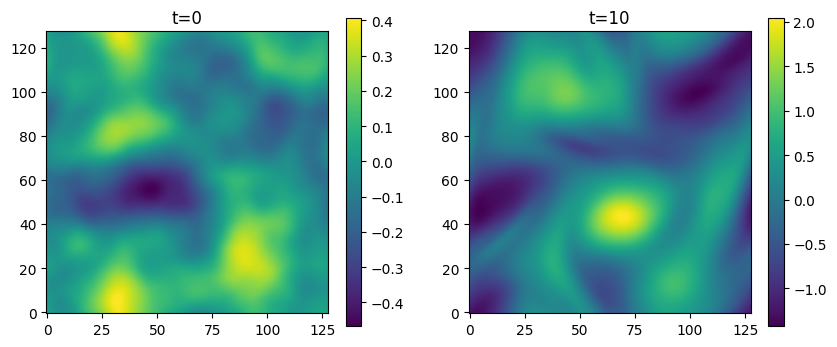

In [66]:
# dataset = CustomNavierStokesDataset(root_dir='./data/navier_stokes', train_resolution=128, batch_size=16, test_batch_sizes=[16], download=True)
sample_0 = dataset[15]  # idx=0: t=0, t=10
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_0['x'][0], cmap='viridis', origin='lower')
plt.title('t=0')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(sample_0['y'][0], cmap='viridis', origin='lower')
plt.title('t=10')
plt.colorbar()
plt.show()

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Darcy Flow 데이터셋 로드 및 입력 채널 확인
train_loader, test_loader, in_channels, out_channels, spatial_dims = get_dataset_loader(
    dataset_name="NavierStokes",
    batch_size=16
)

# FNO 모델 초기화
pretrained_model1 = FNO(in_channels=in_channels, device=device)
pretrained_model2 = UNet(in_channels=in_channels, out_channels=out_channels, hidden_channels=64).to(device)
pretrained_model3 = DeepONet(input_dim=128*128, H=128, W=128).to(device)

epochs = 10
seed=0
torch.cuda.empty_cache()
torch.manual_seed(seed)

model1 = copy.deepcopy(pretrained_model1).to(device)
model2 = copy.deepcopy(pretrained_model2).to(device)
model3 = copy.deepcopy(pretrained_model3).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models1 = []
train_loss_save1 = []
test_loss_save1 = []
for epoch in tqdm(range(epochs)):
    model1, weight1, loss1 = fine_tune(model1, optimizer1, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save1.append(loss1)
    # fine_tuned_models1.append(weight1)
    test_loss1 = evaluate(model1, test_loader, device)
    test_loss_save1.append(test_loss1)
    if epoch == 0:
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)
        save_model1 = 0
        save_weight1 = 0
    elif test_loss1 == min(test_loss_save1):
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)
        prior_model1 = save_model1
        prior_weight1 = save_weight1
    else:
        save_model1 = copy.deepcopy(model1)
        save_weight1 = copy.deepcopy(weight1)

torch.cuda.empty_cache()
# fine_tuned_models2 = []
train_loss_save2 = []
test_loss_save2 = []
for epoch in tqdm(range(epochs)):
    model2, weight2, loss2 = fine_tune(model2, optimizer2, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save2.append(loss2)
    # fine_tuned_models2.append(weight2)
    test_loss2 = evaluate(model2, test_loader, device)
    test_loss_save2.append(test_loss2)
    if epoch == 0:
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)
        save_model2 = 0
        save_weight2 = 0
    elif test_loss2 == min(test_loss_save2):
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)
        prior_model2 = save_model2
        prior_weight2 = save_weight2
    else:
        save_model2 = copy.deepcopy(model2)
        save_weight2 = copy.deepcopy(weight2)

torch.cuda.empty_cache()
# fine_tuned_models3 = []
train_loss_save3 = []
test_loss_save3 = []
for epoch in tqdm(range(epochs)):
    model3, weight3, loss3 = fine_tune(model3, optimizer3, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save3.append(loss3)
    # fine_tuned_models3.append(weight3)
    test_loss3 = evaluate(model3, test_loader, device)
    test_loss_save3.append(test_loss3)
    if epoch == 0:
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)
        save_model3 = 0
        save_weight3 = 0
    elif test_loss3 == min(test_loss_save3):
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)
        prior_model3 = save_model3
        prior_weight3 = save_weight3
    else:
        save_model3 = copy.deepcopy(model3)
        save_weight3 = copy.deepcopy(weight3)

Loading test db for resolution 128 with 100 samples 
Raw x shape: torch.Size([1, 128, 128]), Raw y shape: torch.Size([1, 128, 128])
Processed input shape: torch.Size([1, 128, 128]), target shape: torch.Size([1, 128, 128])


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


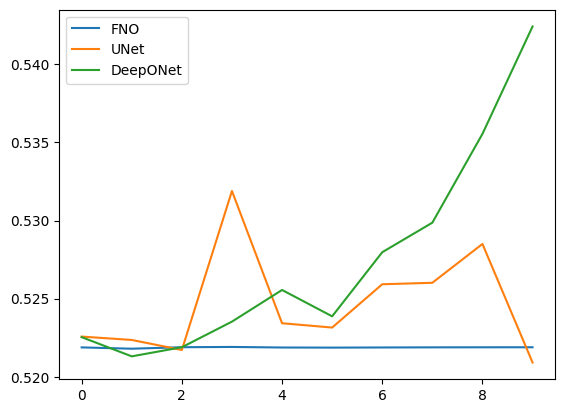

In [62]:
import matplotlib.pyplot as plt
plt.plot(range(100)[:], test_loss_save1[:], label='FNO')
plt.plot(range(100)[:], test_loss_save2[:], label='UNet')
plt.plot(range(100)[:], test_loss_save3[:], label='DeepONet')
plt.legend()
plt.show()

In [27]:
torch.cuda.empty_cache()
# Study Group 학습
model12 = copy.deepcopy(pretrained_model1).to(device)
model21 = copy.deepcopy(pretrained_model2).to(device)
optimizer12 = torch.optim.Adam(model12.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer21 = torch.optim.Adam(model21.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11 = []
train_loss_save12 = []
test_loss_save12 = []
# fine_tuned_models22 = []
train_loss_save21 = []
test_loss_save21 = []
for epoch in tqdm(range(epochs)):
    model12, model21, weight12, weight21, loss12, loss21 = studygroup(model12, model21, optimizer12, optimizer21, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save12.append(loss12)
    # fine_tuned_models12.append(weight12)
    test_loss12 = evaluate(model12, test_loader, device)
    test_loss_save12.append(test_loss12)
    if epoch == 0:
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
    elif test_loss12 == min(test_loss_save12):
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
        
    train_loss_save21.append(loss21)
    # fine_tuned_models21.append(weight21)
    test_loss21 = evaluate(model21, test_loader, device)
    test_loss_save21.append(test_loss21)
    if epoch == 0:
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)
        save_model21 = 0
        save_weight21 = 0
    elif test_loss21 == min(test_loss_save21):
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)


100%|███████████████████████████████████████| 1000/1000 [50:56<00:00,  3.06s/it]


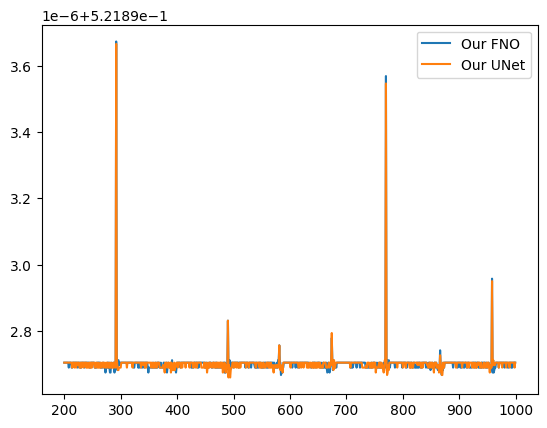

In [40]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save12[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save21[200:], label='Our UNet')
plt.legend()
plt.show()

In [29]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_base2 = evaluate(best_model2, test_loader, device)
mse_study12 = evaluate(best_model12, test_loader, device)
mse_study21 = evaluate(best_model21, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study12 MSE: {mse_study12}")
print(f"Model Study21 MSE: {mse_study21}")

Model Base1 MSE: 0.521786242723465
Model Base2 MSE: 0.5217967256903648
Model Study12 MSE: 0.5218473076820374
Model Study21 MSE: 0.5217196345329285


In [30]:
torch.cuda.empty_cache()
# Study Group 학습
model13 = copy.deepcopy(pretrained_model1).to(device)
model31 = copy.deepcopy(pretrained_model3).to(device)
optimizer13 = torch.optim.Adam(model13.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer31 = torch.optim.Adam(model31.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models13 = []
train_loss_save13 = []
test_loss_save13 = []
# fine_tuned_models31 = []
train_loss_save31 = []
test_loss_save31 = []
for epoch in tqdm(range(epochs)):
    model13, model31, weight13, weight31, loss13, loss31 = studygroup(model13, model31, optimizer13, optimizer31, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save13.append(loss13)
    # fine_tuned_models13.append(weight13)
    test_loss13 = evaluate(model13, test_loader, device)
    test_loss_save13.append(test_loss13)
    if epoch == 0:
        best_model13 = copy.deepcopy(model13)
        best_weight13 = copy.deepcopy(weight13)
    elif test_loss13 == min(test_loss_save13):
        best_model13 = copy.deepcopy(model13)
        best_weight13 = copy.deepcopy(weight13)
        
    train_loss_save31.append(loss31)
    # fine_tuned_models31.append(weight31)
    test_loss31 = evaluate(model31, test_loader, device)
    test_loss_save31.append(test_loss31)
    if epoch == 0:
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)
    elif test_loss31 == min(test_loss_save31):
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)


  4%|█▌                                       | 39/1000 [01:28<36:28,  2.28s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save13[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save31[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [ ]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study13 = evaluate(best_model13, test_loader, device)
mse_study31 = evaluate(best_model31, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study13 MSE: {mse_study13}")
print(f"Model Study31 MSE: {mse_study31}")

In [ ]:
torch.cuda.empty_cache()
# Study Group 학습
model23 = copy.deepcopy(pretrained_model2).to(device)
model32 = copy.deepcopy(pretrained_model3).to(device)
optimizer23 = torch.optim.Adam(model23.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer32 = torch.optim.Adam(model32.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save23 = []
test_loss_save23 = []
# fine_tuned_models32 = []
train_loss_save32 = []
test_loss_save32 = []
for epoch in tqdm(range(epochs)):
    model23, model32, weight23, weight32, loss23, loss32 = studygroup(model23, model32, optimizer23, optimizer32, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save23.append(loss23)
    # fine_tuned_models23.append(weight23)
    test_loss23 = evaluate(model23, test_loader, device)
    test_loss_save23.append(test_loss23)
    if epoch == 0:
        best_model23 = copy.deepcopy(model23)
        best_weight23 = copy.deepcopy(weight23)
    elif test_loss23 == min(test_loss_save23):
        best_model23 = copy.deepcopy(model23)
        best_weight23 = copy.deepcopy(weight23)
        
    train_loss_save32.append(loss32)
    # fine_tuned_models32.append(weight32)
    test_loss32 = evaluate(model32, test_loader, device)
    test_loss_save32.append(test_loss32)
    if epoch == 0:
        best_model32 = copy.deepcopy(model32)
        best_weight32 = copy.deepcopy(weight32)
    elif test_loss32 == min(test_loss_save32):
        best_model32 = copy.deepcopy(model32)
        best_weight32 = copy.deepcopy(weight32)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save23[200:], label='Our UNet')
plt.plot(range(1000)[200:], test_loss_save32[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [ ]:
# 평가
mse_base2 = evaluate(best_model2, test_loader, device)
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study23 = evaluate(best_model23, test_loader, device)
mse_study32 = evaluate(best_model32, test_loader, device)

print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study23 MSE: {mse_study23}")
print(f"Model Study32 MSE: {mse_study32}")

In [ ]:
torch.cuda.empty_cache()
# Study Group 학습
model11a = copy.deepcopy(pretrained_model1).to(device)
model11b = copy.deepcopy(pretrained_model1).to(device)
optimizer11a = torch.optim.Adam(model11a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer11b = torch.optim.Adam(model11b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11a = []
train_loss_save11a = []
test_loss_save11a = []
# fine_tuned_models11b = []
train_loss_save11b = []
test_loss_save11b = []
for epoch in tqdm(range(epochs)):
    model11a, model11b, weight11a, weight11b, loss11a, loss11b = studygroup(model11a, model11b, optimizer11a, optimizer11b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save11a.append(loss11a)
    # fine_tuned_models23.append(weight23)
    test_loss11a = evaluate(model11a, test_loader, device)
    test_loss_save11a.append(test_loss11a)
    if epoch == 0:
        best_model11a = copy.deepcopy(model11a)
        best_weight11a = copy.deepcopy(weight11a)
    elif test_loss11a == min(test_loss_save11a):
        best_model11a = copy.deepcopy(model11a)
        best_weight11a = copy.deepcopy(weight11a)
        
    train_loss_save11b.append(loss11b)
    # fine_tuned_models11b.append(weight11b)
    test_loss11b = evaluate(model11b, test_loader, device)
    test_loss_save11b.append(test_loss11b)
    if epoch == 0:
        best_model11b = copy.deepcopy(model11b)
        best_weight11b = copy.deepcopy(weight11b)
    elif test_loss11b == min(test_loss_save11b):
        best_model11b = copy.deepcopy(model11b)
        best_weight11b = copy.deepcopy(weight11b)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save11a[200:], label='Our FNO1', color='C2')
plt.plot(range(1000)[200:], test_loss_save11b[200:], label='Our FNO2', color='C3')
plt.legend()
plt.show()

In [ ]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_study11a = evaluate(best_model11a, test_loader, device)
mse_study11b = evaluate(best_model11b, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Study11a MSE: {mse_study11a}")
print(f"Model Study11b MSE: {mse_study11b}")

In [ ]:
torch.cuda.empty_cache()
# Study Group 학습
model22a = copy.deepcopy(pretrained_model2).to(device)
model22b = copy.deepcopy(pretrained_model2).to(device)
optimizer22a = torch.optim.Adam(model22a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer22b = torch.optim.Adam(model22b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models22a = []
train_loss_save22a = []
test_loss_save22a = []
# fine_tuned_models22b = []
train_loss_save22b = []
test_loss_save22b = []
for epoch in tqdm(range(epochs)):
    model22a, model22b, weight22a, weight22b, loss22a, loss22b = studygroup(model22a, model22b, optimizer22a, optimizer22b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save22a.append(loss22a)
    # fine_tuned_models22.append(weight22)
    test_loss22a = evaluate(model22a, test_loader, device)
    test_loss_save22a.append(test_loss22a)
    if epoch == 0:
        best_model22a = copy.deepcopy(model22a)
        best_weight22a = copy.deepcopy(weight22a)
    elif test_loss22a == min(test_loss_save22a):
        best_model22a = copy.deepcopy(model22a)
        best_weight22a = copy.deepcopy(weight22a)\
        
    train_loss_save22b.append(loss22b)
    # fine_tuned_models22b.append(weight22b)
    test_loss22b = evaluate(model22b, test_loader, device)
    test_loss_save22b.append(test_loss22b)
    if epoch == 0:
        best_model22b = copy.deepcopy(model11b)
        best_weight22b = copy.deepcopy(weight11b)
    elif test_loss22b == min(test_loss_save22b):
        best_model22b = copy.deepcopy(model22b)
        best_weight22b = copy.deepcopy(weight22b)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save22a[200:], label='Our UNet1', color='C2')
plt.plot(range(1000)[200:], test_loss_save22b[200:], label='Our UNet2', color='C3')
plt.legend()
plt.show()

In [ ]:
# 평가
mse_base2 = evaluate(best_model2, test_loader, device)
mse_study22a = evaluate(best_model22a, test_loader, device)
mse_study22b = evaluate(best_model22b, test_loader, device)

print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study22a MSE: {mse_study22a}")
print(f"Model Study22b MSE: {mse_study22b}")

In [35]:
torch.cuda.empty_cache()
# Study Group 학습
model33a = copy.deepcopy(pretrained_model3).to(device)
model33b = copy.deepcopy(pretrained_model3).to(device)
optimizer33a = torch.optim.Adam(model33a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer33b = torch.optim.Adam(model33b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models33a = []
train_loss_save33a = []
test_loss_save33a = []
# fine_tuned_models33b = []
train_loss_save33b = []
test_loss_save33b = []
for epoch in tqdm(range(epochs)):
    model33a, model33b, weight33a, weight33b, loss33a, loss33b = studygroup(model33a, model33b, optimizer33a, optimizer33b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save33a.append(loss33a)
    # fine_tuned_models33.append(weight33)
    test_loss33a = evaluate(model33a, test_loader, device)
    test_loss_save33a.append(test_loss33a)
    if epoch == 0:
        best_model33a = copy.deepcopy(model33a)
        best_weight33a = copy.deepcopy(weight33a)
    elif test_loss33a == min(test_loss_save33a):
        best_model33a = copy.deepcopy(model33a)
        best_weight33a = copy.deepcopy(weight33a)
        
    train_loss_save33b.append(loss33b)
    # fine_tuned_models33b.append(weight33b)
    test_loss33b = evaluate(model33b, test_loader, device)
    test_loss_save33b.append(test_loss33b)
    if epoch == 0:
        best_model33b = copy.deepcopy(model33b)
        best_weight33b = copy.deepcopy(weight33b)
    elif test_loss33b == min(test_loss_save33b):
        best_model33b = copy.deepcopy(model33b)
        best_weight33b = copy.deepcopy(weight33b)


100%|███████████████████████████████████████| 1000/1000 [11:15<00:00,  1.48it/s]


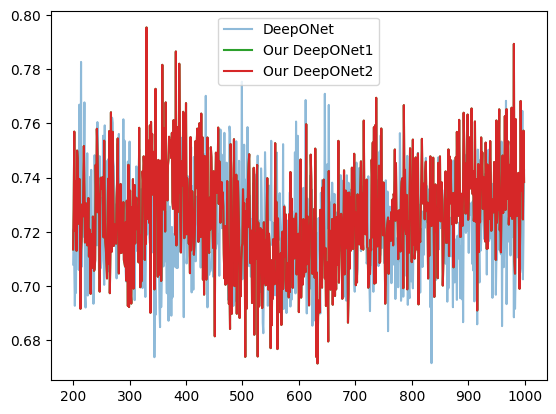

In [36]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save33a[200:], label='Our DeepONet1', color='C2')
plt.plot(range(1000)[200:], test_loss_save33b[200:], label='Our DeepONet2', color='C3')
plt.legend()
plt.show()

In [37]:
# 평가
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study33a = evaluate(best_model33a, test_loader, device)
mse_study33b = evaluate(best_model33b, test_loader, device)

print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study33a MSE: {mse_study33a}")
print(f"Model Study33b MSE: {mse_study33b}")

Model Base3 MSE: 0.5336290821433067
Model Study33a MSE: 0.5366771519184113
Model Study33b MSE: 0.5366771519184113
